# Modelling whether a player plays
As mentioned earlier, the goal of this analysis is to find the players we might want to select for our fantasy football team. There is considerable flexibility in how this can be approached. From the previous analysis, a binary classification of whether a player scores four or more points appears to be a good starting point. To make the problem more tractable in one of the other notebooks I have also create a separate model of whether a player will play or not. As shown earlier, about half of all players will not play in a game. If we combine a value predicting whether a player is likely to play or not with a value for their predicted points assuming they do play, we will easily be able to select good players.

In [39]:
import os
import pickle
import warnings
import re
import json
import datetime

import boto3
import keyring
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeavePGroupsOut, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# Use sklearn API for easy inclusion in sklearn pipelines
from xgboost.sklearn import XGBClassifier
from sklearn.exceptions import DataConversionWarning

from helpers import PercentageCalc

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
%matplotlib inline
pd.options.display.max_columns = None

data = pd.read_csv('./data/model_data.csv')

# TODO: drop this unwanted column in exploratory notebook
data.drop(columns=['team_goals_conceded'], inplace=True)

In the previous modelling notebook I made a model which predicts whether a player plays or not. This means that for this model, we can model with our population being those who *do* play, not all players. This is helpful as if we were using every player every game, there would be a large amount of class imbalance. There are techniques which could be used to combat this which might be worth looking into in the future (over/undersampling etc.).

To make this approach actually useful, when scoring new players, I will simply predict whether they are likely to play, and then predict the high points for all, assuming they are to play. Then, to filter good players, it is simply a case of highlighting those predicted to play (model 1 - previous notebook) **and** score highly (model 2 - this notebook).

In [2]:
data.head()

,player_id,player_name,fixture_id,fixture_id_long,gameweek_id,total_points,fixture_home,value,transfers_balance,selected,transfers_in,transfers_out,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away,opponent_team_id,opponent_team_strength,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,team_fixture_difficulty,opponent_team_fixture_difficulty,total_minutes,previous_points,previous_home_team_score,previous_away_team_score,previous_minutes,previous_goals_scored,previous_assists,previous_clean_sheets,previous_goals_conceded,previous_own_goals,previous_penalties_saved,previous_penalties_missed,previous_yellow_cards,previous_red_cards,previous_saves,previous_bonus,previous_bps,previous_influence,previous_creativity,previous_threat,previous_ict_index,previous_team_goals_scored,previous_win,previous_loss,previous_draw,kickoff_feature_sin,kickoff_feature_cos,kickoff_feature_game_day_of_week,kickoff_feature_time_diff,kickoff_feature_gameday,fifa_age,fifa_height_cm,fifa_weight_kg,fifa_overall,fifa_potential,fifa_value_eur,fifa_wage_eur,fifa_international_reputation,fifa_weak_foot,fifa_skill_moves,fifa_release_clause_eur,fifa_pace,fifa_shooting,fifa_passing,fifa_dribbling,fifa_defending,fifa_physic,fifa_gk_diving,fifa_gk_handling,fifa_gk_kicking,fifa_gk_reflexes,fifa_gk_speed,fifa_gk_positioning,fifa_attacking_crossing,fifa_attacking_finishing,fifa_attacking_heading_accuracy,fifa_attacking_short_passing,fifa_attacking_volleys,fifa_skill_dribbling,fifa_skill_curve,fifa_skill_fk_accuracy,fifa_skill_long_passing,fifa_skill_ball_control,fifa_movement_acceleration,fifa_movement_sprint_speed,fifa_movement_agility,fifa_movement_reactions,fifa_movement_balance,fifa_power_shot_power,fifa_power_jumping,fifa_power_stamina,fifa_power_strength,fifa_power_long_shots,fifa_mentality_aggression,fifa_mentality_interceptions,fifa_mentality_positioning,fifa_mentality_vision,fifa_mentality_penalties,fifa_mentality_composure,fifa_defending_marking,fifa_defending_standing_tackle,fifa_defending_sliding_tackle,fifa_goalkeeping_diving,fifa_goalkeeping_handling,fifa_goalkeeping_kicking,fifa_goalkeeping_positioning,fifa_goalkeeping_reflexes,fifa_work_rate_attack,fifa_work_rate_defense,fifa_ptag_,fifa_ptag_distanceshooter,fifa_ptag_completedefender,fifa_ptag_completemidfielder,fifa_ptag_acrobat,fifa_ptag_speedster,fifa_ptag_poacher,fifa_ptag_fkspecialist,fifa_ptag_clinicalfinisher,fifa_ptag_tactician,fifa_ptag_aerialthreat,fifa_ptag_completeforward,fifa_ptag_tackling,fifa_ptag_playmaker,fifa_ptag_crosser,fifa_ptag_engine,fifa_ptag_strength,fifa_ptag_dribbler,fifa_ptrait_,fifa_ptrait_powerfree-kick,fifa_ptrait_longthrow-in,fifa_ptrait_inflexible,fifa_ptrait_selfish,fifa_ptrait_acrobaticclearance,fifa_ptrait_finesseshot,fifa_ptrait_beatoffsidetrap,fifa_ptrait_crowdfavourite,fifa_ptrait_skilleddribbling,fifa_ptrait_flair,fifa_ptrait_giantthrow-in,fifa_ptrait_diver,fifa_ptrait_flairpasses,fifa_ptrait_injuryfree,fifa_ptrait_outsidefootshot,fifa_ptrait_leadership,fifa_ptrait_injuryprone,fifa_ptrait_argueswithofficials,fifa_ptrait_secondwind,fifa_ptrait_avoidsusingweakerfoot,fifa_ptrait_swervepass,fifa_ptrait_earlycrosser,fifa_pbodytype_stocky,fifa_pbodytype_lean,fifa_pbodytype_normal,fifa_preferred_foot_right,fifa_is_uk_roi_player,fifa_pos_rf,fifa_pos_ldm,fifa_pos_ram,fifa_pos_lm,fifa_pos_lcm,fifa_pos_cm,fifa_pos_rcm,fifa_pos_rm,fifa_pos_lwb,fifa_pos_cdm,fifa_pos_rdm,fifa_pos_rwb,fifa_pos_lb,fifa_pos_lcb,fifa_pos_cb,fifa_pos_rcb,fifa_pos_rb,fifa_pos_cam,fifa_pos_lam,fifa_pos_rw,fifa_pos_ls,fifa_pos_st,fifa_pos_rs,fifa_pos_lf,fifa_pos_cf,fifa_pos_lw,position_name_FWD,position_name_GKP,position_name_MID,team_name_AVL,team_name_BHA,team_name_BOU,team_name_BUR,team_name_CHE,team_name_CRY,team_

In [3]:
data_played = data.loc[data['target_played']].copy()
data_played.dropna(inplace=True)
print(f'Proportion of data useable: {len(data_played)/len(data):.2%}')

Proportion of data useable: 46.18%


As we now have much fewer rows to work with compared to the previous notebook, I won't look to add on the additional features introduced in that notebook (as this data is only available for later data - using it would reduce our data size even more). On the plus side, that additional data is less useful here anyway - the only variable which might help is `form`, though the data we have available has proxies for this (previous gameweek stats).

In [4]:
print(f'Proportion of data with positive label: {data_played["target_points"].mean():.2%}')

Proportion of data with positive label: 24.48%


There is still some class imbalance. As a result, unlike the previous notebook where I could use accuracy as my evaluation metric, I will use ROC AUC.

The approach in this notebook, on the whole, will be similar to the other notebook. Therefore need to split data so players only appear in either the training or test set.

In [72]:
player_ids = np.unique(data_played.player_id)

player_ids_use, player_ids_test = train_test_split(player_ids, test_size=0.2,
                                                  random_state=53)

data_use = data_played.loc[data_played.player_id.isin(player_ids_use)]
data_test = data_played.loc[data_played.player_id.isin(player_ids_test)]

## Base model
A first model we can do is simply say that if a player scored highly in the last game, they will do so again.

In [73]:
class BaseModel():
    def fit(X, y):
        pass
    
    def predict(X, y=None):
        return (X['previous_points'] >= 4).astype(int)

preds_train = BaseModel.predict(data_use)
preds_test = BaseModel.predict(data_test)

roc_base = roc_auc_score(data_test['target_points'].astype(int), preds_test)
print(f'ROC AUC of base model (test data): {roc_base}')

ROC AUC of base model (test data): 0.5279446003721867


Better than random guessing, but definitely room for improvement!

### Selecting columns to use

In [74]:
data_played.head()

,player_id,player_name,fixture_id,fixture_id_long,gameweek_id,total_points,fixture_home,value,transfers_balance,selected,transfers_in,transfers_out,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away,opponent_team_id,opponent_team_strength,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,team_fixture_difficulty,opponent_team_fixture_difficulty,total_minutes,previous_points,previous_home_team_score,previous_away_team_score,previous_minutes,previous_goals_scored,previous_assists,previous_clean_sheets,previous_goals_conceded,previous_own_goals,previous_penalties_saved,previous_penalties_missed,previous_yellow_cards,previous_red_cards,previous_saves,previous_bonus,previous_bps,previous_influence,previous_creativity,previous_threat,previous_ict_index,previous_team_goals_scored,previous_win,previous_loss,previous_draw,kickoff_feature_sin,kickoff_feature_cos,kickoff_feature_game_day_of_week,kickoff_feature_time_diff,kickoff_feature_gameday,fifa_age,fifa_height_cm,fifa_weight_kg,fifa_overall,fifa_potential,fifa_value_eur,fifa_wage_eur,fifa_international_reputation,fifa_weak_foot,fifa_skill_moves,fifa_release_clause_eur,fifa_pace,fifa_shooting,fifa_passing,fifa_dribbling,fifa_defending,fifa_physic,fifa_gk_diving,fifa_gk_handling,fifa_gk_kicking,fifa_gk_reflexes,fifa_gk_speed,fifa_gk_positioning,fifa_attacking_crossing,fifa_attacking_finishing,fifa_attacking_heading_accuracy,fifa_attacking_short_passing,fifa_attacking_volleys,fifa_skill_dribbling,fifa_skill_curve,fifa_skill_fk_accuracy,fifa_skill_long_passing,fifa_skill_ball_control,fifa_movement_acceleration,fifa_movement_sprint_speed,fifa_movement_agility,fifa_movement_reactions,fifa_movement_balance,fifa_power_shot_power,fifa_power_jumping,fifa_power_stamina,fifa_power_strength,fifa_power_long_shots,fifa_mentality_aggression,fifa_mentality_interceptions,fifa_mentality_positioning,fifa_mentality_vision,fifa_mentality_penalties,fifa_mentality_composure,fifa_defending_marking,fifa_defending_standing_tackle,fifa_defending_sliding_tackle,fifa_goalkeeping_diving,fifa_goalkeeping_handling,fifa_goalkeeping_kicking,fifa_goalkeeping_positioning,fifa_goalkeeping_reflexes,fifa_work_rate_attack,fifa_work_rate_defense,fifa_ptag_,fifa_ptag_distanceshooter,fifa_ptag_completedefender,fifa_ptag_completemidfielder,fifa_ptag_acrobat,fifa_ptag_speedster,fifa_ptag_poacher,fifa_ptag_fkspecialist,fifa_ptag_clinicalfinisher,fifa_ptag_tactician,fifa_ptag_aerialthreat,fifa_ptag_completeforward,fifa_ptag_tackling,fifa_ptag_playmaker,fifa_ptag_crosser,fifa_ptag_engine,fifa_ptag_strength,fifa_ptag_dribbler,fifa_ptrait_,fifa_ptrait_powerfree-kick,fifa_ptrait_longthrow-in,fifa_ptrait_inflexible,fifa_ptrait_selfish,fifa_ptrait_acrobaticclearance,fifa_ptrait_finesseshot,fifa_ptrait_beatoffsidetrap,fifa_ptrait_crowdfavourite,fifa_ptrait_skilleddribbling,fifa_ptrait_flair,fifa_ptrait_giantthrow-in,fifa_ptrait_diver,fifa_ptrait_flairpasses,fifa_ptrait_injuryfree,fifa_ptrait_outsidefootshot,fifa_ptrait_leadership,fifa_ptrait_injuryprone,fifa_ptrait_argueswithofficials,fifa_ptrait_secondwind,fifa_ptrait_avoidsusingweakerfoot,fifa_ptrait_swervepass,fifa_ptrait_earlycrosser,fifa_pbodytype_stocky,fifa_pbodytype_lean,fifa_pbodytype_normal,fifa_preferred_foot_right,fifa_is_uk_roi_player,fifa_pos_rf,fifa_pos_ldm,fifa_pos_ram,fifa_pos_lm,fifa_pos_lcm,fifa_pos_cm,fifa_pos_rcm,fifa_pos_rm,fifa_pos_lwb,fifa_pos_cdm,fifa_pos_rdm,fifa_pos_rwb,fifa_pos_lb,fifa_pos_lcb,fifa_pos_cb,fifa_pos_rcb,fifa_pos_rb,fifa_pos_cam,fifa_pos_lam,fifa_pos_rw,fifa_pos_ls,fifa_pos_st,fifa_pos_rs,fifa_pos_lf,fifa_pos_cf,fifa_pos_lw,position_name_FWD,position_name_GKP,position_name_MID,team_name_AVL,team_name_BHA,team_name_BOU,team_name_BUR,team_name_CHE,team_name_CRY,team_

In [75]:
cross_val_replace_cols = ['selected', 'transfers_in', 'transfers_out']
not_features = ['target_played', 'target_points', 'total_minutes',
               'opponent_team_id', 'home_team_id', 'away_team_id',
               'total_points', 'position_id', 'team_id',
                'player_id', 'player_name', 'fixture_id', 'fixture_id_long'
               ]
features = [c for c in data_use.columns if c not in not_features and
           c not in cross_val_replace_cols]

X_all = data_use.loc[:, features + cross_val_replace_cols]
y_all = data_use.loc[:, 'target_points']

X_test = data_test.loc[:, features + cross_val_replace_cols]
y_test = data_test.loc[:, 'target_points']

### PCA
Again, as with the predicting players playing notebook, there is a need to both reduce the number of features (more so in this case as we have fewer observations to use!) and reduce collinearity. PCA is a simple solution. I won't repeat the investigation here as it would be identical to that in the other notebook, but we need roughly 96 components to explain 95% of variance in the data.

## Simple logistic regression
Again, following the same procedures as the previous notebook.

In [76]:
def cross_val_scorer_grouped(estimator, params, X, y=None, groups=None, scoring='accuracy', scorer=roc_auc_score,
                             cv_outer=5, cv_inner='warn', test_split_outer=0.2, gs_verbosity=1):
    
    gss = GroupShuffleSplit(n_splits=cv_outer, test_size=test_split_outer)
    gss.split(X_all, y_all, groups=grps)

    # For each cross validation fold, calculate the accuracy of a tuned (inner cross validation classifier) defined by
    # the input estimator
    scores = np.zeros(cv_outer)

    for i, (train, test) in enumerate(gss.split(X, y, groups=groups)):
        print(i)
        X_train = X.iloc[train, :]
        X_test = X.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        g_train = groups.iloc[train]

        # Fit the model for this fold's training data
        gs = GridSearchCV(estimator=estimator, param_grid=params, scoring=scoring, cv=cv_inner, verbose=gs_verbosity, n_jobs=-1)
        gs.fit(X_train, y_train, groups=g_train)
        preds = gs.predict(X_test)

        # Get the score for this fold
        scores[i] = scorer(y_test, preds)
        print('Fold {} complete'.format(i))
        
    return scores, gs

grps = data_use.loc[:, 'player_id']

As mentioned previously, I'm only doing this on my laptop (actually a VM with even more limited compute!) so I won't be able to do much hyperparameter tuning. Xgboost in the previous notebook took a long time even for a small set of parameters, so I will stick with logistic regression for now, as I only really need to look at regularisation.

Another thing to consider is the class imbalance. The imbalance I have isn't that bad, but sklearn's logistic regression implementation has a `class_weight` parameter which can help. I'll set this as `balanced` to assist; this will also have the benefit of making probabilities higher (otherwise due to the imbalance 'true' predictions will have relatively low probabilities). If the model performs poorly on the imbalanced data, there are over/undersampling techniques which could be used.

In [99]:
pipe_lr = Pipeline(
    [('rpcol', PercentageCalc(by_group='gameweek_id',
                             variables=['selected', 'transfers_in', 'transfers_out'],
                             constant=15,
                            drop_by=False)),
     ('ss', StandardScaler()),
     ('pca', PCA(n_components=0.95, svd_solver='full')),
     ('sbf', SelectKBest(f_classif)),
     ('clf', LogisticRegression(solver='liblinear', random_state=42))]
)
params_lr = {
#      'pca__n_components': [0.5, 0.9, 0.95, None],
     'sbf__k': ['all', 10, 20, 50],
     'clf__penalty': ['l1', 'l2'],
     'clf__C': np.logspace(-5, 1, 7),
     'clf__class_weight': ['balanced']
}
gkf = GroupKFold(n_splits=5)

In [100]:
gs = GridSearchCV(estimator=pipe_lr, param_grid=params_lr,
                  scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
_ = gs.fit(X_all, y_all, groups=grps)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  3.0min finished


In [203]:
preds_lr_train = gs.predict_proba(X_all)
train_score = roc_auc_score(y_all, preds_lr_train[:, 1])
print(f'Best model train performance: {train_score:.4f}')

preds_lr_test = gs.predict_proba(X_test)
test_score = roc_auc_score(y_test, preds_lr_test[:, 1])
print(f'Best model test performance: {test_score:.4f}')

Best model train performance: 0.6647
Best model test performance: 0.6311


In [115]:
pipe_rf = Pipeline(
    [('rpcol', PercentageCalc(by_group='gameweek_id',
                             variables=['selected', 'transfers_in', 'transfers_out'],
                             constant=15,
                            drop_by=False)),
     ('ss', StandardScaler()),
     ('pca', PCA(n_components=0.95, svd_solver='full')),
     ('sbf', SelectKBest(f_classif)),
     ('clf', RandomForestClassifier(random_state=42, n_estimators=100))]
)
params_rf = {
#      'pca__n_components': [0.5, 0.9, 0.95, None],
     #'sbf__k': ['all', 10, 20, 50],
     'clf__max_depth': [2, 4, 10, None],
    'clf__max_features': ['auto', 0.3, 0.5]
}
gs2 = GridSearchCV(estimator=pipe_rf, param_grid=params_rf,
                  scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
_ = gs2.fit(X_all, y_all, groups=grps)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   31.2s finished


In [116]:
preds_rf_train = gs2.predict_proba(X_all)
train_score = roc_auc_score(y_all, preds_rf_train[:, 1])
print(f'Best model test performance: {train_score:.4f}')

preds_rf_test = gs2.predict_proba(X_test)
test_score = roc_auc_score(y_test, preds_rf_test[:, 1])
print(f'Best model test performance: {test_score:.4f}')

Best model test performance: 0.7096
Best model test performance: 0.6183


In [117]:
gs.best_params_

{'clf__max_depth': 4}

There may be small amount of overfitting going on here, but not enough to worry me. For now I will use probably use this as my points prediction model, but I will just sense check some of the results first.

It should be noted, for our purposes, the returned probability is appropriate (we don't need to go about choosing a threshold value) to make the outcome dichotomous.

In [105]:
sense_check_train = data_use.copy()
sense_check_train['set'] = 'TRAIN'
sense_check_train['predicted_points'] = preds_lr_train[:, 1]

sense_check_test = data_test.copy()
sense_check_test['set'] = 'TEST'
sense_check_test['predicted_points'] = preds_lr_test[:, 1]

sense_check_all = pd.concat((sense_check_train, sense_check_test))

sense_check_all.sort_values('predicted_points', ascending=False).head(10)

,player_id,player_name,fixture_id,fixture_id_long,gameweek_id,total_points,fixture_home,value,transfers_balance,selected,transfers_in,transfers_out,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away,opponent_team_id,opponent_team_strength,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,team_fixture_difficulty,opponent_team_fixture_difficulty,total_minutes,previous_points,previous_home_team_score,previous_away_team_score,previous_minutes,previous_goals_scored,previous_assists,previous_clean_sheets,previous_goals_conceded,previous_own_goals,previous_penalties_saved,previous_penalties_missed,previous_yellow_cards,previous_red_cards,previous_saves,previous_bonus,previous_bps,previous_influence,previous_creativity,previous_threat,previous_ict_index,previous_team_goals_scored,previous_win,previous_loss,previous_draw,kickoff_feature_sin,kickoff_feature_cos,kickoff_feature_game_day_of_week,kickoff_feature_time_diff,kickoff_feature_gameday,fifa_age,fifa_height_cm,fifa_weight_kg,fifa_overall,fifa_potential,fifa_value_eur,fifa_wage_eur,fifa_international_reputation,fifa_weak_foot,fifa_skill_moves,fifa_release_clause_eur,fifa_pace,fifa_shooting,fifa_passing,fifa_dribbling,fifa_defending,fifa_physic,fifa_gk_diving,fifa_gk_handling,fifa_gk_kicking,fifa_gk_reflexes,fifa_gk_speed,fifa_gk_positioning,fifa_attacking_crossing,fifa_attacking_finishing,fifa_attacking_heading_accuracy,fifa_attacking_short_passing,fifa_attacking_volleys,fifa_skill_dribbling,fifa_skill_curve,fifa_skill_fk_accuracy,fifa_skill_long_passing,fifa_skill_ball_control,fifa_movement_acceleration,fifa_movement_sprint_speed,fifa_movement_agility,fifa_movement_reactions,fifa_movement_balance,fifa_power_shot_power,fifa_power_jumping,fifa_power_stamina,fifa_power_strength,fifa_power_long_shots,fifa_mentality_aggression,fifa_mentality_interceptions,fifa_mentality_positioning,fifa_mentality_vision,fifa_mentality_penalties,fifa_mentality_composure,fifa_defending_marking,fifa_defending_standing_tackle,fifa_defending_sliding_tackle,fifa_goalkeeping_diving,fifa_goalkeeping_handling,fifa_goalkeeping_kicking,fifa_goalkeeping_positioning,fifa_goalkeeping_reflexes,fifa_work_rate_attack,fifa_work_rate_defense,fifa_ptag_,fifa_ptag_distanceshooter,fifa_ptag_completedefender,fifa_ptag_completemidfielder,fifa_ptag_acrobat,fifa_ptag_speedster,fifa_ptag_poacher,fifa_ptag_fkspecialist,fifa_ptag_clinicalfinisher,fifa_ptag_tactician,fifa_ptag_aerialthreat,fifa_ptag_completeforward,fifa_ptag_tackling,fifa_ptag_playmaker,fifa_ptag_crosser,fifa_ptag_engine,fifa_ptag_strength,fifa_ptag_dribbler,fifa_ptrait_,fifa_ptrait_powerfree-kick,fifa_ptrait_longthrow-in,fifa_ptrait_inflexible,fifa_ptrait_selfish,fifa_ptrait_acrobaticclearance,fifa_ptrait_finesseshot,fifa_ptrait_beatoffsidetrap,fifa_ptrait_crowdfavourite,fifa_ptrait_skilleddribbling,fifa_ptrait_flair,fifa_ptrait_giantthrow-in,fifa_ptrait_diver,fifa_ptrait_flairpasses,fifa_ptrait_injuryfree,fifa_ptrait_outsidefootshot,fifa_ptrait_leadership,fifa_ptrait_injuryprone,fifa_ptrait_argueswithofficials,fifa_ptrait_secondwind,fifa_ptrait_avoidsusingweakerfoot,fifa_ptrait_swervepass,fifa_ptrait_earlycrosser,fifa_pbodytype_stocky,fifa_pbodytype_lean,fifa_pbodytype_normal,fifa_preferred_foot_right,fifa_is_uk_roi_player,fifa_pos_rf,fifa_pos_ldm,fifa_pos_ram,fifa_pos_lm,fifa_pos_lcm,fifa_pos_cm,fifa_pos_rcm,fifa_pos_rm,fifa_pos_lwb,fifa_pos_cdm,fifa_pos_rdm,fifa_pos_rwb,fifa_pos_lb,fifa_pos_lcb,fifa_pos_cb,fifa_pos_rcb,fifa_pos_rb,fifa_pos_cam,fifa_pos_lam,fifa_pos_rw,fifa_pos_ls,fifa_pos_st,fifa_pos_rs,fifa_pos_lf,fifa_pos_cf,fifa_pos_lw,position_name_FWD,position_name_GKP,position_name_MID,team_name_AVL,team_name_BHA,team_name_BOU,team_name_BUR,team_name_CHE,team_name_CRY,team_

The high scoring players look like those you would expect (even after removing features which directly determine a player) which is promising. However, most of the higher scoring players seem to be those in the training set, suggesting the model is less able to predict high probabilities for unseen data.

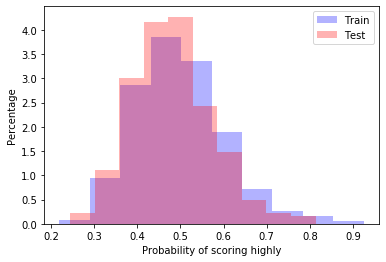

In [111]:
fig = plt.figure()
plt.hist(preds_lr_train[:, 1], color='blue', alpha=0.3, density=True, label='Train')
plt.hist(preds_lr_test[:, 1], color='red', alpha=0.3, density=True, label='Test')
plt.legend()
plt.xlabel('Probability of scoring highly')
plt.ylabel('Percentage')
plt.show()

In [125]:
from scipy.stats import ks_2samp
ks_2samp(preds_lr_train[:, 1], preds_lr_test[:, 1])

Ks_2sampResult(statistic=0.08684623957738045, pvalue=1.0)

The distributions appear similar. I will cautiously continue for now but it might be worth returning later to investigate further (it may just be the case the higher scoring players happened to be in the training data).

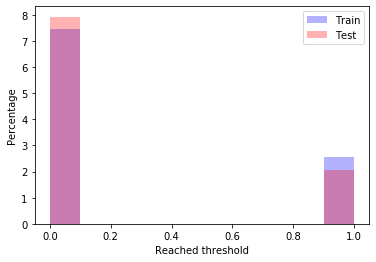

In [132]:
fig = plt.figure()
plt.hist(data_use['target_points'].astype(int), color='blue', alpha=0.3, density=True, label='Train')
plt.hist(data_test['target_points'].astype(int), color='red', alpha=0.3, density=True, label='Test')
plt.legend()
plt.xlabel('Above points threshold')
plt.ylabel('Percentage')
plt.show()

It looks as though this is the case. Unfortunately, it's not trivial to fix this due to the way I've done my train test split (and gridsearch CV) - it is more important for groups to be retained. However, if this is the explanation, you might expect new players (which are to be high performing) would still be predicted as high performing.

### Feature importances
For interest, and as an additional sense-check, it's worth looking at which features contributed the most. Using a logistic regression it would be simplest to look at features with the highest coefficient sizes (seeing as data was standarised in the pipeline). However, having the PCA step complicates this somewhat. An easier alternative is to look at correlations between each feature (non-PCA) and the predicted response. This is quite a naive way of doing things, but for sense checking it should be sufficient.

In [ ]:
check_corr_cols = [c for c in sense_check_all.columns if c not in
                  not_features + ['gameweek_id', 'set']]
correlations = sense_check_all.loc[:, check_corr_cols].corr()

correlations_with_target = correlations.loc[:, 'predicted_points']
correlations_with_target.dropna(inplace=True)

The main features which, the higher they are, the more likely a positive prediction is made.

In [113]:
correlations_sorted = correlations_with_target.drop('predicted_points').sort_values(ascending=False)
print('Most positively correlated variables with the predicted_points response:')
correlations_sorted.head(10)

Most positively correlated variables with the predicted_points response:


selected                   0.593481
previous_ict_index         0.511565
value                      0.497197
previous_influence         0.496892
previous_bps               0.496797
fifa_value_eur             0.488161
fifa_release_clause_eur    0.486367
previous_points            0.485967
transfers_in               0.482645
fifa_wage_eur              0.438554
Name: predicted_points, dtype: float64

These look as you might expect. `Selected` (which is turned into a percentage in a pipeline step) shows perhaps wisdom of the crowds - more people will choose high-performance players! Similarly, for higher value stats (e.g. wages, transfers, FPL cost), and things like previous influence and points, you would also imagine more points being scored.

For features which appear to have be result in lower chances of scoring well the higher they are:

In [114]:
print('Most negatively correlated variables with the target_total_points response:')
correlations_sorted.tail(10)

Most negatively correlated variables with the target_total_points response:


opponent_team_name_LIV                -0.248024
position_name_MID                     -0.306151
opponent_team_strength_defence_away   -0.410500
opponent_team_strength_defence_home   -0.420261
opponent_team_strength                -0.437733
opponent_team_strength_attack_away    -0.440993
team_fixture_difficulty               -0.445636
opponent_team_strength_overall_away   -0.458349
opponent_team_strength_attack_home    -0.459377
opponent_team_strength_overall_home   -0.464561
Name: predicted_points, dtype: float64

Again, this looks about right. The strength of the opponent team negatively correlates with how well a player might score. Interestingly, midfielders appear to be less likely to score as well.

## Summary
This looks fine for now, in the future I might come back and try additional models and feature selection steps.

Another thing to try, as discussed in the exploratory notebook, would be try to regression models to predict points directly, rather than whether a player scores above a threshold. However, as mentioned earlier, this will be much more challenging, and the scores on the more limited classification approach above don't fill me with confidence points will be able to be predicted particularly accurately.

In [202]:
import io
model_vers = '00'
model_out_key_start = f'models/points/model_{model_vers}/'
model_key_end = 'model.pkl'

s3 = boto3.client('s3')

buff = io.BytesIO()

obj = pickle.dumps(gs)
s3.put_object(Bucket='fpl-alldata', Key=model_out_key_start + model_key_end, Body=obj)

{'ResponseMetadata': {'RequestId': 'E0211C464B726E33',
  'HostId': 'q7TTvmzqxR/4QnAV5duJSR4Qr529cz0PdZ55W0cFoHzQQG4D7a43MqY1eHqp0a0NiWI5PhojvzM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'q7TTvmzqxR/4QnAV5duJSR4Qr529cz0PdZ55W0cFoHzQQG4D7a43MqY1eHqp0a0NiWI5PhojvzM=',
   'x-amz-request-id': 'E0211C464B726E33',
   'date': 'Sun, 14 Jun 2020 15:50:32 GMT',
   'x-amz-version-id': 'SCjGMttL_hypH0igegnm_mJOpbkf2Jen',
   'etag': '"5331c5f2425740f2752f135c37fba23a"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"5331c5f2425740f2752f135c37fba23a"',
 'VersionId': 'SCjGMttL_hypH0igegnm_mJOpbkf2Jen'}

In [204]:
from datetime import datetime

metadata_key_end = 'metadata.json'
metadata = {
    'general': {
        'version': model_vers,
        'datetime': f'{datetime.now():%Y-%m-%d %H:%M:%S%z}',
    },
    'model': {
        'metrics': {
            'roc_auc_score': {
                'train': train_score,
                'test': test_score
            }
        }
    },
    'data': {
        'source': './data/model_data.csv',
        'misc': 'Data subsetted to those which played a game'
    }    
}

obj = json.dumps(metadata)
s3.put_object(Bucket='fpl-alldata',
              Key=model_out_key_start + metadata_key_end,
              Body=obj)

{'ResponseMetadata': {'RequestId': '91DC599844B5A1C2',
  'HostId': 'vok4DVaqJnXmGIAv6mikOVmIYMhIdMFPHLGCuytmSFInvbLbLwJHpogWTCFxqykRIiHCDygwxwY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'vok4DVaqJnXmGIAv6mikOVmIYMhIdMFPHLGCuytmSFInvbLbLwJHpogWTCFxqykRIiHCDygwxwY=',
   'x-amz-request-id': '91DC599844B5A1C2',
   'date': 'Sun, 14 Jun 2020 15:52:55 GMT',
   'x-amz-version-id': 'TAbpRhVt9er.y3v0gfs39qdotNRliceN',
   'etag': '"b8836b9af790b923dee9ce79f5ad505f"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"b8836b9af790b923dee9ce79f5ad505f"',
 'VersionId': 'TAbpRhVt9er.y3v0gfs39qdotNRliceN'}

Quick look at trying to map coefficients from model to features by (for want of a more correct word) 'inverting' the PCA step.

In [201]:
## Looking at coefficients
# From: https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
features = [f for f in features
            if f not in ['gameweek_id', 'selected',
                         'transfers_in', 'transfers_out'] +
            ['selected_perc', 'transfers_in_perc', 'transfer_out_perc']]

pca_step = gs.best_estimator_.named_steps['pca']
n_pcs = pca_step.components_.shape[0]
pca_comps = pca_step.components_
most_important = [np.abs(pca_comps[i]).argmax() for i in range(n_pcs)]
#print(len(features))

x = pd.DataFrame(most_important, columns=['feature_index'])
x.index.rename('component', inplace=True)


y = pd.DataFrame(features, columns=['feature_name'])
y.index.rename('feature_index', inplace=True)
y.reset_index(inplace=True)

z = x.merge(y, how='left', on='feature_index', validate='many_to_one')
z.drop(columns=['feature_index'], inplace=True)
z.index.rename('component', inplace=True)
z.reset_index()
z['coeff'] = gs.best_estimator_.named_steps['clf'].coef_.reshape(-1, 1)
z['abs_coeff'] = z['coeff'].abs()
z['type'] = np.where(z['coeff'] > 0, 'Positive', 'Negative')
z.sort_values('abs_coeff', ascending=False).head(10)

,feature_name,coeff,abs_coeff,type
component,,,,
4,previous_home_team_score,0.074919,0.074919,Positive
3,opponent_team_strength_attack_home,-0.062676,0.062676,Negative
6,team_name_AVL,-0.062337,0.062337,Negative
1,transfers_balance,0.060724,0.060724,Positive
48,opponent_team_name_MCI,0.059922,0.059922,Positive
8,NaN,0.051265,0.051265,Positive
7,fifa_ptag_poacher,0.043844,0.043844,Positive
16,fifa_ptrait_swervepass,-0.041366,0.041366,Negative
10,fifa_pbodytype_normal,0.033042,0.033042,Positive
